# Neural networks programming with Tensorflow

There exist also some other neural network programming frameworks like [Tensorflow](https://www.tensorflow.org/), for example [PaddlePaddle](http://www.paddlepaddle.org/), [PyTorch](https://pytorch.org/), [Caffe](http://caffe.berkeleyvision.org/), [Keras](https://keras.io/), [Deeplearning4J](https://deeplearning4j.org).

Programming in Tensorflow generally consists of the following steps:

1. Create tensors or variables (that are not yet executed/evaluated).
2. Write operations between tensors and variables.
3. Initialize tensors.
4. Create a session.
5. Run the session (actually running the operations above).

Check the Tensorflow version (v2 is not compatible with v1):

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

print(tf.__version__)

2.0.0


### Simple example

An example of multiplying two numbers:

In [2]:
a = tf.constant(4)
b = tf.constant(5)
c = tf.multiply(a, b)
print(c)

Tensor("Mul:0", shape=(), dtype=int32)


The result is not 20 but a tensor without shape attribute and of type *int32*. The result above is the definition of a *computation graph*, which has not been yet run to actually compute the two numbers. To do so, we need to create a new session and run it:

In [3]:
session = tf.compat.v1.Session()
print(session.run(c))
session.close()

20


Now we got the result of our computation graph.

### Parameters for the Tensorflow program

Sometimes we do not know all the parameters in advance and would like to additionally feed data later during execution (e.g. training examples). These parameters are known as placeholders and are passed when running as a *feed_dictionary* (`feed_dict` parameter). For example:

In [4]:
# Read value from a user
x = input("Enter a number to multiply with 5: ")

# Define the computation graph
a = tf.compat.v1.placeholder(tf.int32, name = 'a')
b = tf.constant(5)
c = tf.multiply(a, b)

# Execute the computation graph
session = tf.compat.v1.Session()
print(session.run(c, feed_dict = {a: x}))
session.close()

Enter a number to multiply with 5: 446
2230


The code above first constructs the computation graph with a placeholder for values to specify later. At last we run the session in order to execute the computation graph.

### Variables computation

Now let's compute the loss of a training example defined as:

$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2$$

In [5]:
y_hat = tf.constant(67, name='y_hat')            
y = tf.constant(69, name='y')                    

loss = tf.Variable((y - y_hat)**2, name='loss')  

init = tf.compat.v1.global_variables_initializer()         
                                                 
with tf.compat.v1.Session() as session:                    
    session.run(init)                            
    print("The loss value of a training example is:", session.run(loss))                     

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The loss value of a training example is: 4


We created a variable for the loss where we defined a function of other quantities. Before the evaluation we needed to call `tf.global_variables_initializer()` that initialized the variable, which was then evaluated during running the session.

To compute the cost of a neural network we need to sum all the losses over all the examples. Tensorflow library already contains prepared functions to compute cost. For example, the function `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)` computes the the cross-entropy losses between logits and labels, while logits are outputs of the last unit before the final sigmoid activation.

### Linear function

Let's compute the following equation: $Z = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

Tensorflow offers a variety of commonly used neural network functions like `tf.sigmoid` or `tf.softmax`. We are now interested to output $sigmoid(Z)$ values.

In [6]:
import numpy as np
import tensorflow as tf
np.random.seed(1)

# Input value
x_value = np.random.randn(3,1)
    
# Neural network graph
X = tf.compat.v1.placeholder(tf.float64, name = "X")
W = tf.Variable(np.random.randn(4,3), name = "W")
b = tf.Variable(np.random.randn(4,1), name = "b")
Z = tf.add(tf.matmul(W,X), b)
sigmoid = tf.sigmoid(Z)        
                            
init = tf.compat.v1.global_variables_initializer()    
    
with tf.compat.v1.Session() as session:    
    train_writer = tf.compat.v1.summary.FileWriter('logs/train', session.graph)
    
    session.run(init)
    sigmoid_result, Z_result = session.run([sigmoid, Z], feed_dict = {X: x_value})
    print("Zs: \n", Z_result)
    print("Sigmoids: \n", sigmoid_result)
    
    train_writer.close()
    

Zs: 
 [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]
Sigmoids: 
 [[0.10371852]
 [0.95068312]
 [0.25175618]
 [0.30040282]]


The example above will return Z values and their sigmoid values. Apart from that, logs for visualization with Tensorboard will be generated in *logs* folder.

[Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is a visualization tool that enables the overview of training status or just prints a graph of a given neural network. To run it, call `tensorboard --logdir=logs` and navigate to [http://localhost:6006](http://localhost:6006) (hint: install a specific version of protobuf if you experience problems: `pip install protobuf==3.8`). 

The example above generates the following structure:

<img src="tensorboard.png" width="800px" />

HINT: If you get weird data, restart the notebook kernel, delete files in logs folder and re-run just this part along with Tensorboard.


### A Tensorflow training example

Let's train a simple linear function, where we optimize RMSE error and use gradient descent optimizer to minimize error. Note that we use `tf.zeros(shape)` for the initialization, alternatively also `tf.ones(shape)` is offered by the Tensorflow.

In [7]:
import numpy as np
import tensorflow as tf
epochs = 200

# Prepare data
x_data = np.random.rand(100).astype(np.float32)
y_data = x_data * 0.1 + 0.3

# Build graph
x = tf.compat.v1.placeholder(tf.float32, shape=[None])
y_ = tf.compat.v1.placeholder(tf.float32, shape=[None])

W = tf.Variable(tf.random.uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x + b

# Update step
loss_mse = tf.reduce_mean(tf.square(y - y_))
train_step = tf.compat.v1.train.GradientDescentOptimizer(0.5).minimize(loss_mse)

# Prepare session
init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)

# Train model
print("%s\t%s\t\t%s\t\t%s" % ("Iteration", "Loss", "W", "b"))
for i in range(epochs):
    sess.run(train_step, feed_dict={x: x_data, y_: y_data})
    
    if i % 20 == 0:
        loss = sess.run(loss_mse, feed_dict={x: x_data, y_: y_data})
        print("%s\t\t%s\t%s\t%s" % (i, loss, sess.run(W)[0], sess.run(b)[0]))

print("\nBest fit should be:\n\t\t\t\t%s\t\t%s" % (0.1, 0.3))
sess.close()

Iteration	Loss		W		b
0		0.007862948	0.2784559	0.27943027
20		9.7085926e-05	0.1319628	0.28251538
40		4.6521773e-06	0.10699673	0.2961726
60		2.229248e-07	0.10153161	0.29916218
80		1.0682457e-08	0.10033528	0.2998166
100		5.121031e-10	0.10007341	0.29995987
120		2.451147e-11	0.10001606	0.29999122
140		1.1811529e-12	0.100003526	0.29999807
160		5.520917e-14	0.10000077	0.2999996
180		2.753353e-15	0.100000165	0.29999992

Best fit should be:
				0.1		0.3


### Recurrent neural networks with Tensorflow

Basic recurrent neural network consist of recurrent units that we can classify into basic, GRU and LSTM:

<table>
  <tr>
      <td><img src="rnn.png" /></td>
      <td><img src="gru.png" /></td>
      <td><img src="lstm.png" /></td>
  </tr>
</table>
<sub>Courtesy of <a href="https://medium.com/@saurabh.rathor092/simple-rnn-vs-gru-vs-lstm-difference-lies-in-more-flexible-control-5f33e07b1e57">https://medium.com/@saurabh.rathor092/simple-rnn-vs-gru-vs-lstm-difference-lies-in-more-flexible-control-5f33e07b1e57</a></sub>

**Simple RNN**: There is a simple multiplication of Input (*xt*) and Previous Output (*ht-1*). Passed through *Tanh* activation function. No Gates present.

**Gated Recurrent Unit (GRU)**: An Update gate is introduced, to decide whether to pass previous output to next cell or not. Forget gate is nothing but additional Mathematical Operations with a new set of weights.

<img src="gru_formula.png" width="500px" />

**Long Short Term Memory Unit (LSTM)**: Two more gates are introduced (Forget and Output) in addition to Update gate of GRU. And again as above, these are additional Mathematical Operations on same inputs (xt and ht-1). So overall, LSTM has introduced two math operations having two new sets of weights.

<img src="lstm_formula.png" width="600px" />

### Recurrent neural networks example

Generated data:
2016-08-31    135.721663
2016-09-30    126.133644
2016-10-31    111.804466
2016-11-30    112.375318
2016-12-31    111.552394
Freq: M, dtype: float64


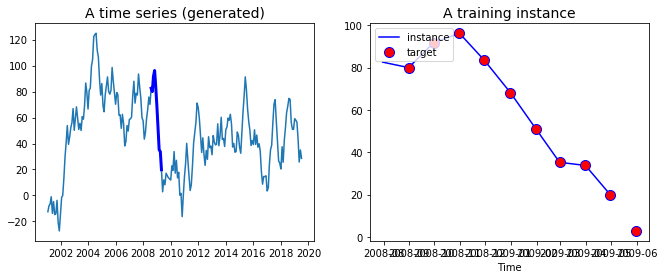

In [8]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts

ts= create_ts(start = '2001', n = 192, freq = 'M')
print(f"Generated data:\n{ts.tail(5)}")

ts = create_ts(start = '2001', n = 222)

# Left
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(ts.index, ts)
plt.plot(ts.index[90:100], ts[90:100], "b-", linewidth=3, label="A training instance")
plt.title("A time series (generated)", fontsize=14)

# Right
plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(ts.index[90:100], ts[90:100], "b-", markersize=8, label="instance")
plt.plot(ts.index[91:101], ts[91:101], "bo", markersize=10, label="target", markerfacecolor='red')
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [11]:
series = np.array(ts)

n_windows = 20   
n_input =  1
n_output = 1
size_train = 201 # 21 points left for testing
r_neuron = 120

## Split data
train = series[:size_train]
test = series[size_train:]
print("Train and test set: ", train.shape, test.shape)

def create_batches(df, windows, input, output):
    ## Create X         
    x_data = train[:size_train-1] 
    X_batches = x_data.reshape(-1, windows, input) 
    ## Create y
    y_data = train[n_output:size_train] # Lag by the number of output!
    y_batches = y_data.reshape(-1, windows, output)
    return X_batches, y_batches
    
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)
X_test, y_test = create_batches(df = test,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)
print("Training data: ", X_batches.shape, y_batches.shape)
print("Testing data: ", X_test.shape, y_test.shape)


tf.compat.v1.reset_default_graph()    

## 1. Construct the tensors
X = tf.compat.v1.placeholder(tf.float32, [None, n_windows, n_input])   
y = tf.compat.v1.placeholder(tf.float32, [None, n_windows, n_output])

## 2. create the model
basic_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=r_neuron, activation=tf.nn.relu)   
rnn_output, states = tf.compat.v1.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)    

# Tricky part for faster computation
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_output, n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])   

## 3. Loss + optimization
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)         
training_op = optimizer.minimize(loss)                                          

init = tf.compat.v1.global_variables_initializer() 

iteration = 1500 

print("\nTraining:")
with tf.compat.v1.Session() as sess:
    train_writer = tf.compat.v1.summary.FileWriter('logs1/train', session.graph)
    
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)

    test_writer = tf.compat.v1.summary.FileWriter('logs1/test', session.graph)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    
    train_writer.close()
    test_writer.close()
    


Train and test set:  (201,) (21,)
Training data:  (10, 20, 1) (10, 20, 1)
Testing data:  (10, 20, 1) (10, 20, 1)

Training:
0 	MSE: 539088.9
150 	MSE: 13943.485
300 	MSE: 4455.365
450 	MSE: 3190.0166
600 	MSE: 2862.4675
750 	MSE: 2575.8423
900 	MSE: 5156.5156
1050 	MSE: 2349.0918
1200 	MSE: 2274.0552
1350 	MSE: 2234.7485


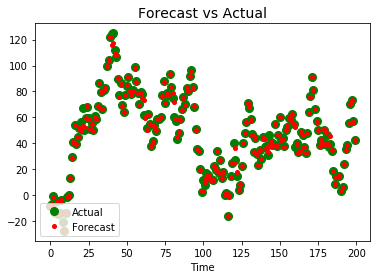

In [10]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()


### Useful references:

* Tensorflow activation functions: [https://www.tensorflow.org/api_guides/python/nn#Activation_Functions](https://www.tensorflow.org/api_guides/python/nn#Activation_Functions)
* [https://www.tensorflow.org/tutorials/sequences/recurrent](https://www.tensorflow.org/tutorials/sequences/recurrent)
* [https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537](https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537)
* [https://www.guru99.com/rnn-tutorial.html](https://www.guru99.com/rnn-tutorial.html) <sub>(Used for the example above)</sub>